# 프로젝트 1
## Momentum Strategy with a Single Asset
### Backtesting Module


### 1) Importing Data

In [28]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [9]:
# Getting 'KODEX 200'etf data from krx
df = fdr.DataReader('069500', exchange= 'krx')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-14,5521,5662,5369,5499,3631647,NaN
2002-10-15,5558,5648,5450,5634,3225163,0.024550
2002-10-16,5692,5692,5598,5658,2873418,0.004260
2002-10-17,5648,5792,5572,5736,2947580,0.013786
2002-10-18,5877,6017,5840,5981,1861880,0.042713
...,...,...,...,...,...,...
2022-01-13,39975,40030,39680,39720,4178583,-0.005135
2022-01-14,39405,39480,39035,39105,4234215,-0.015483
2022-01-17,39105,39145,38600,38820,5841437,-0.007288


### 2) Calculating Daily Returns

In [12]:
returns_df = df.pct_change()
returns_df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-14,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,0.006702,-0.002473,0.015087,0.024550,-0.111928,NaN
2002-10-16,0.024109,0.007790,0.027156,0.004260,-0.109063,-0.826482
2002-10-17,-0.007730,0.017569,-0.004645,0.013786,0.025810,2.236214
2002-10-18,0.040545,0.038847,0.048098,0.042713,-0.368336,2.098313
...,...,...,...,...,...,...
2022-01-13,0.010874,0.002379,0.003795,-0.005135,-0.033506,-1.312695
2022-01-14,-0.014259,-0.013740,-0.016255,-0.015483,0.013314,2.015483
2022-01-17,-0.007613,-0.008485,-0.011144,-0.007288,0.379580,-0.529297


In [14]:
# check if the column 'Change' from df is daily_returns of 'Close' price
returns_df['Close'].equals(df['Change'])

True

### 3) Creating Momentum Signals

In [43]:
class SingleAssetMomentum():
    def __init__(self, price, lookback_period, cost=0.003, signal_method='macd', long_only=False):

        if signal_method == 'ma':
            self.signal = self.moving_average_breakthrough(price, long_only)
        elif signal_method == 'ma_co':
            self.signal = self.moving_average_crossover(price, long_only)
        elif signal_method == 'cb':
            self.signal = self.channel_breakthrough(price, long_only)
        elif signal_method == 'macd':
            self.signal = self.macd(price, long_only)

        self.rebalance_weight = 1 / holding_period
        
        self.cost = self.transaction_cost(self.signal, cost)


    def moving_average_breakthrough(self, price, long_only=False):
        """Returns Moving Average Signals"""
        mv_avrg = price.rolling(window=20).mean()
        long_signal = (price > mv_avrg).applymap(self.bool_converter)
        short_signal = -(price < mv_avrg).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal


    def moving_average_crossover(self, price, long_only=False):
        """Returns Moving Average Crossover Signals"""
        shrt_mv_avrg = price.rolling(window=20).mean()
        long_mv_avrg = price.rolling(window=200).mean()
        long_signal = (shrt_mv_avrg > long_mv_avrg).applymap(self.bool_converter)
        short_signal = -(shrt_mv_avrg < long_mv_avrg).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal


    def channel_breakthrough(self, price, long_only=False):
        """Returns Channel Breakthrough Signals"""
        high_price_chnl = price.rolling(window=20).max()
        low_price_chnl = price.rolling(window=20).min()
        long_signal = (price > high_price_chnl).applymap(self.bool_converter)
        long_exit_signal = -(price < high_price_chnl).applymap(self.bool_converter)
        short_signal = -(price < low_price_chnl).applymap(self.bool_converter)
        short_exit_signal = (price > low_price_chnl).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal or short_exit_signal
        else:
            signal = long_signal + short_signal + long_exit_signal + short_exit_signal
        return signal


    def macd(self, price, long_only=False):
        """Returns MACD Signals"""
        macd = price.rolling(window=12).mean() - price.rolling(window=26).mean()
        signl = price.rolling(window=9).mean()
        long_signal = macd > signl
        short_signal = -(macd < signl)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal


    def transaction_cost(self, signal, cost=0.003):
        """Returns Transaction Costs"""
        cost_df = (signal.diff() != 0) * cost
        cost_df.iloc[0] = 0
        return cost_df


    def bool_converter(self, bool_val):
        """Returns Integer Values from Boolean Value which represents trading signals"""
        if bool_val == True:
            result = 1
        elif bool_var == False:
            result = 0
        return result


if __name__ == "__main__":
    price = df['Close']
    lookback_period = 240
    momentum = SingleAssetMomentum(price, lookback_period)

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [58]:
macd_signal = momentum.macd(price, long_only=False).astype('int')
macd_signal

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


Date
2002-10-14    1
2002-10-15    1
2002-10-16    1
2002-10-17    1
2002-10-18    1
             ..
2022-01-13    0
2022-01-14    0
2022-01-17    0
2022-01-18    0
2022-01-19    0
Name: Close, Length: 4768, dtype: int64

In [53]:
cum_rtn_sr = ((macd_signal * df['Change']) + 1).cumprod().dropna()
cum_rtn_sr # 보통 우상향하는 

Date
2002-10-15    1.024550
2002-10-16    1.028914
2002-10-17    1.043099
2002-10-18    1.087652
2002-10-21    1.058192
                ...   
2022-01-13    1.096927
2022-01-14    1.096927
2022-01-17    1.096927
2022-01-18    1.096927
2022-01-19    1.096927
Length: 4767, dtype: float64

### 4) Plotting a Graph on Asset Performance


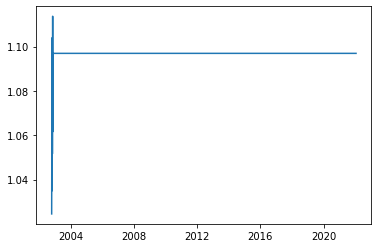

In [66]:
plt.plot(cum_rtn_sr)